<a href="https://colab.research.google.com/github/aaronts3004/Emotion-Recognition-CNN/blob/main/EmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# install required packages, if not installed
# ! pip install torch torchvision matplotlib pandas numpy torchmetrics

#### Import packages

In [5]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchmetrics import ConfusionMatrix
from PIL import Image
import kagglehub as kh
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
from torch import Tensor

## Part 1: Importing and loading the data
The dataset used to train the model is the FER-2013 CSV file. It contains 48x48 pixels images labeled with a respective emotion (e.g. 0=Angry, 1=Angry, etc.). The downloaded directory contains 2 further sub-directories, 'train' and 'test'. Both of these contain image sub-folders, with the label being used as the respective sub-folder name. Find more information on https://www.kaggle.com/datasets/msambare/fer2013<br>
<br>
Directory Structure
<hr>
root/<br>
|-----&nbsp;&nbsp;train/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;sad/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;happy/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;...<br>
|-----&nbsp;&nbsp;test/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;sad/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;happy/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-------&nbsp;...<br>
<br>
<hr>

Total Number of Images: 32'298 Images<br>
Size of Train Directory: 28'709 Images (88%)<br>
Size of Test Directory: 3'589 Images (12%)<br>
Training directory is further split into 90% training (25'838 Images) and 10% validation (2871 Images)<br>
<hr>





In [6]:
# Download the dataset directory from KaggleHub.

full_path = Path(kh.dataset_download("msambare/fer2013"))
print("Path to dataset files:", full_path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 153MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [7]:
def get_data_loaders(full_path, batch_size=32, pre_trained=False):
    """
    Returns train, validation, and testset DataLoader objects.

    Args:
        data_dir (str): Path to the dataset directory.
        batch_size (int): Batch size for DataLoader.
        pre_trained (bool): Boolean flag, set if using a pre-trained model.

    Returns:
        train_loader, val_loader, test_loader: DataLoader objects for training, validation and testing.
    """

    # pre-trained models expect different parameters and image dimensions
    # If true, apply transforms for pretrained models (e.g., VGG, ResNet)
    if pre_trained:
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
            transforms.Resize((224, 224)),  # Resize to 224x224
            transforms.RandomHorizontalFlip(),  # Flip images horizontally
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
    else: # Apply transforms for custom CNN (48x48, 1 channel)
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((48, 48)),  # Keep original size
            transforms.RandomHorizontalFlip(),  # Flip images horizontally
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
        ])

    # Load the full train dataset from directory and split it further into train and validation
    train_full_dataset = datasets.ImageFolder(root=full_path / "train", transform=transform)

    # Reserve 10% of the training data for validation
    train_size = int(0.9 * len(train_full_dataset))
    val_size = len(train_full_dataset) - train_size
    train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

    # Load the test set (as the 2nd sub-directory in the root dataset directory)
    path_test = full_path / "test"
    test_dataset = datasets.ImageFolder(root=full_path / "test", transform=transform)

    # Create all the respective dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [9]:
# Create DataLoaders to train the custom model
train_dataloader, val_dataloader, test_dataloader = get_data_loaders(full_path, batch_size=32, pre_trained=False)

print("Initialized DataLoaders for custom model:")
print(f"Training set size: {len(train_dataloader.dataset)}")
print(f"Validation set size: {len(val_dataloader.dataset)}")
print(f"Test set size: {len(test_dataloader.dataset)}")

Initialized DataLoaders for custom model:
Training set size: 25838
Validation set size: 2871
Test set size: 7178


In [10]:
# Print the size of the feature tensors for a single sample batch

for X,y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 1, 48, 48])
Shape of y: torch.Size([32]) torch.int64


In [11]:
# Map the numerical encoding of the labels in the dataset (0 to 7)
# to the respective categorical string labels
train_full_dataset = datasets.ImageFolder(root=full_path / "train")     # needed to retrieve the labels
label_to_class = {v: k for k, v in train_full_dataset.class_to_idx.items()}
print(label_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


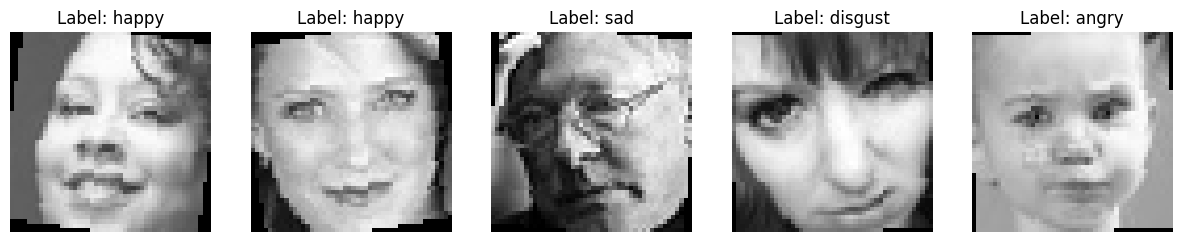

In [12]:
# Visualize some examples to ensure loading correctness
# Retrieve a single batch of data from the training set dataloader - the batch will contain two tensors (features, labels)
images, labels = next(iter(train_dataloader))

# Plot the first 5 images and labels from this batch
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].squeeze().numpy()
    label = label_to_class[labels[i].item()]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()

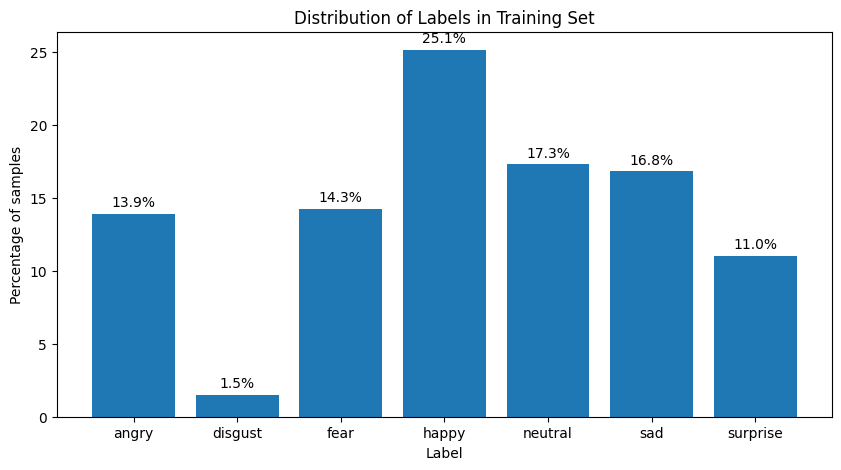

In [13]:
# Visualize the class distributions of the labels in the training dataset
label_counts = {}
for _, label_index in train_full_dataset:
    string_label = label_to_class[label_index]
    if string_label in label_counts:
        label_counts[string_label] += 1
    else:
        label_counts[string_label] = 1
# Normalize the counts
total_samples = len(train_full_dataset)
label_distribution = {label: (count / total_samples)*100 for label, count in label_counts.items()}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(label_distribution.keys(), label_distribution.values())
ax.set_xlabel('Label')
ax.set_ylabel('Percentage of samples')
ax.set_title('Distribution of Labels in Training Set')

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

From the distribution we can see that the the 'happy' label has the most samples, which could make the model tend towards over-predicting the 'happy' class (*due to imbalanced dataset*).

## Part 2: Training the neural network and creating a model



---
First, I tried training the neural network with a very simple but custom CNN architecture composed of multiple convolutional layers.<br>
<br>Next, since I couldn't get a high enough accuracy, I tried chaning the architecture to a residual neural network, since it is supposed to be better at feature extraction. <br><br>
Finally, since I still wasn't happy with the accuracy, I adapted the pre-trained VGG-16 Pytorch neural network to run on this dataset. I thought about comparing the performance with the pre-trained model to see if the custom models may have some mistakes, but the pre-trained model achieved the lowest accuracy.
<hr>

The first CNN architecture is composed of:<br>
* 4 Convolutional layers + batch normalization
* 2 fully connected layers

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 3 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


<hr>
ResNet Architecture:<br>


*   4 Residual Layers + 1 final linear layer


<hr>

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding='same',
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding='same',
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=(3, 3),
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: Tensor) -> Tensor:
        identity = self.downsample(x) if self.downsample else x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x

In [16]:
class ResCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=(3, 3),
            padding='same',
            bias=False
        )

        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        # First block of residual layers and pooling
        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # Second block of residual layers and pooling
        self.layer2 = nn.Sequential(
            ResidualBlock(16, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # Third block of residual layers and pooling
        self.layer3 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # Fourth block of residual layers and pooling
        self.layer4 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(
            in_features=1152,
            out_features=num_classes
        )

    def forward(self, x: Tensor) -> Tensor:
      x = self.conv(x)
      x = self.bn(x)
      x = self.relu(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.flatten(x)
      x = self.dropout(x)
      x = self.linear(x)

      return x



## Training and Hyperparameter Optimization


In [17]:
def train(train_loader, val_loader, model, loss_fn, optimizer, num_epochs = 10):
    '''
      Defines the training loop for a PyTorch model

      Args:
        dataloader (DataLoader): DataLoader object with the training data
        model (nn.Module): The neural network on which to train the model
        loss_fn(Y_hat, Y_labels): loss function
        optimizer: optimizer to use during training
        num_epochs (int): number of epochs to train for

      Returns:
        None
    '''
    # Use Adam optimizer if input is None
    if optimizer is None:
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # For early stopping
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)


    # Iterate over epochs
    for epoch in range(num_epochs):
        model.train()     # set training mode
        running_loss,correct,total = 0.0,0,0

        # Train
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # perform a forward pass and calculate the training loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # zero out the gradients, perform the backpropagation step,
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            # update the confusion matrix
            confmat.update(predicted, y)

        # Update training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        metrics["train_acc"].append(train_acc)
        metrics["train_loss"].append(train_loss)

        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)           # Forward pass
                loss = loss_fn(pred, y)
                val_loss += loss.item()     # Loss update
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()    # Correct predictions

            # Validation metrics
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total
            metrics["val_loss"].append(val_loss)
            metrics["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )
        scheduler.step()

    print("Done training!")
    return metrics, confmat

In [18]:
def plot_metrics(metrics):
  '''
    Plots training and validation loss and accuracy next to each other

    Args:
      metrics (dict): dictionary containing the training and validation loss and accuracy
  '''


  # Create a figure with two subplots
  fig, axes = plt.subplots(1, 2, figsize=(16, 5))

  # Plot training and validation accuracy
  axes[0].plot(metrics["train_acc"], label='Training Accuracy')
  axes[0].plot(metrics["val_acc"], label='Validation Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].legend()

  # Plot training and validation loss
  axes[1].plot(metrics["train_loss"], label='Training Loss')
  axes[1].plot(metrics["val_loss"], label='Validation Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_title('Training and Validation Loss')
  axes[1].legend()

  plt.tight_layout()
  plt.show()

### 1. Training the Simple CNN

In [19]:
# Get cpu, gpu or mps device for training, if available.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
# general variables
model_cnn = SimpleCNN()      # choose between "SimpleCNN", "ResCNN", or "VGG-16"
num_classes = 10

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Define loss function, scheduler and optimizer to train the neural network
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate, weight_decay = 1e-6)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
# Train the model!
model_cnn = model_cnn.to(device)
metrics,confmat = train(train_dataloader, val_dataloader, model_cnn, loss_fn, optimizer, num_epochs)

Epoch 1/10, Train Loss: 1.7033, Train Acc: 30.49%, Val Loss: 1.5149, Val Acc: 37.76%
Epoch 2/10, Train Loss: 1.5566, Train Acc: 36.70%, Val Loss: 1.4666, Val Acc: 39.18%
Epoch 3/10, Train Loss: 1.5011, Train Acc: 39.50%, Val Loss: 1.4344, Val Acc: 39.53%
Epoch 4/10, Train Loss: 1.4615, Train Acc: 41.09%, Val Loss: 1.3900, Val Acc: 45.45%
Epoch 5/10, Train Loss: 1.4270, Train Acc: 42.84%, Val Loss: 1.3074, Val Acc: 49.60%
Epoch 6/10, Train Loss: 1.4018, Train Acc: 44.04%, Val Loss: 1.3145, Val Acc: 48.17%
Epoch 7/10, Train Loss: 1.3794, Train Acc: 45.34%, Val Loss: 1.2662, Val Acc: 49.36%
Epoch 8/10, Train Loss: 1.3660, Train Acc: 45.43%, Val Loss: 1.2587, Val Acc: 50.82%
Epoch 9/10, Train Loss: 1.3461, Train Acc: 46.27%, Val Loss: 1.2604, Val Acc: 52.77%
Epoch 10/10, Train Loss: 1.3466, Train Acc: 46.25%, Val Loss: 1.2561, Val Acc: 53.19%
Done training!


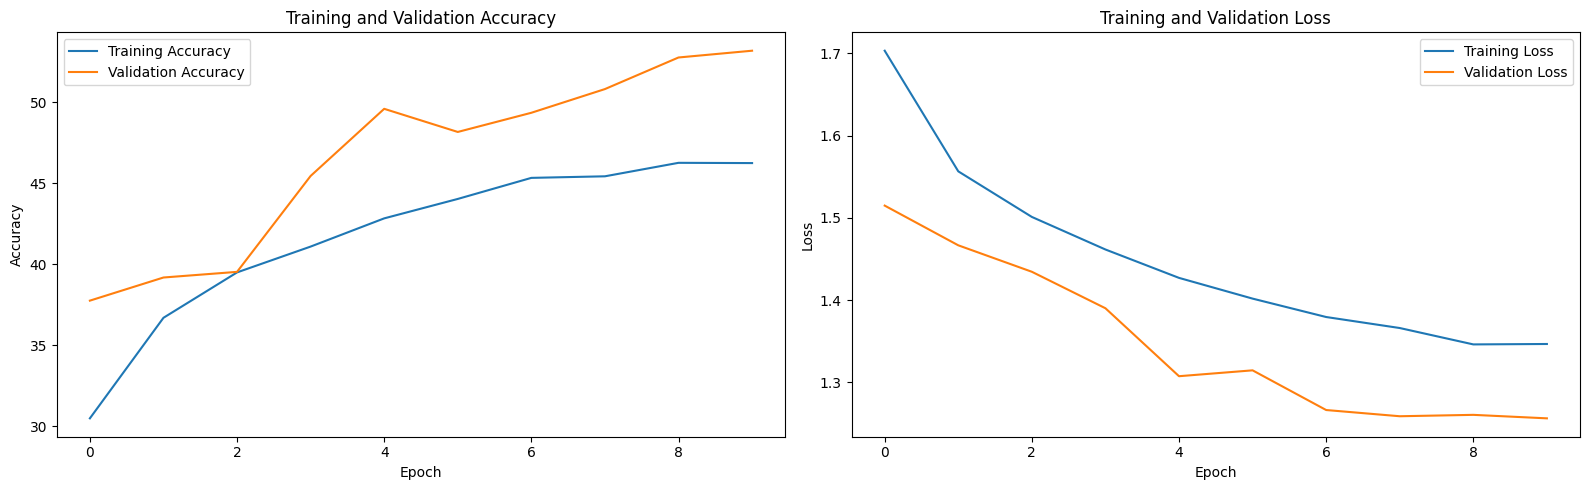

tensor([[ 4962,     0,  1645,  5434,  5892, 16278,  1409,     0,     0,     0],
        [  737,     1,   170,   511,   414,  1960,   137,     0,     0,     0],
        [ 2928,     1,  2919,  4722,  5069, 15718,  5343,     0,     0,     0],
        [  695,     6,  1227, 50162,  3483,  7655,  2122,     0,     0,     0],
        [ 1771,     3,  1528,  8133, 15860, 16269,  1066,     0,     0,     0],
        [ 3857,     2,  1620,  6509, 10433, 20111,  1018,     0,     0,     0],
        [  330,     1,  1907,  2846,  1095,  8449, 13972,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')


In [22]:
# plot the final metrics
plot_metrics(metrics)
confmat = confmat.compute()
print(confmat)

### 2. Training the custom ResNet

In [23]:
# general variables
model_res = ResCNN(num_classes)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Define loss function, scheduler and optimizer to train the neural network
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_res.parameters(), lr=learning_rate, weight_decay = 1e-6)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


print(f"Using {device} device")
model_res = model_res.to(device)

# Training
metrics_res, confmat = train(train_dataloader, val_dataloader, model_res, loss_fn, optimizer, num_epochs)

Using cuda device
Epoch 1/10, Train Loss: 1.7942, Train Acc: 28.92%, Val Loss: 1.5924, Val Acc: 36.99%
Epoch 2/10, Train Loss: 1.4631, Train Acc: 42.98%, Val Loss: 1.5191, Val Acc: 41.38%
Epoch 3/10, Train Loss: 1.3161, Train Acc: 49.35%, Val Loss: 1.4443, Val Acc: 44.76%
Epoch 4/10, Train Loss: 1.2269, Train Acc: 53.09%, Val Loss: 1.2638, Val Acc: 51.10%
Epoch 5/10, Train Loss: 1.1642, Train Acc: 55.88%, Val Loss: 1.2279, Val Acc: 54.20%
Epoch 6/10, Train Loss: 1.1113, Train Acc: 57.78%, Val Loss: 1.1762, Val Acc: 55.83%
Epoch 7/10, Train Loss: 1.0715, Train Acc: 59.61%, Val Loss: 1.0857, Val Acc: 58.90%
Epoch 8/10, Train Loss: 1.0408, Train Acc: 60.83%, Val Loss: 1.0764, Val Acc: 59.11%
Epoch 9/10, Train Loss: 1.0044, Train Acc: 62.41%, Val Loss: 1.0802, Val Acc: 59.28%
Epoch 10/10, Train Loss: 0.9810, Train Acc: 62.94%, Val Loss: 1.0800, Val Acc: 59.80%
Done training!


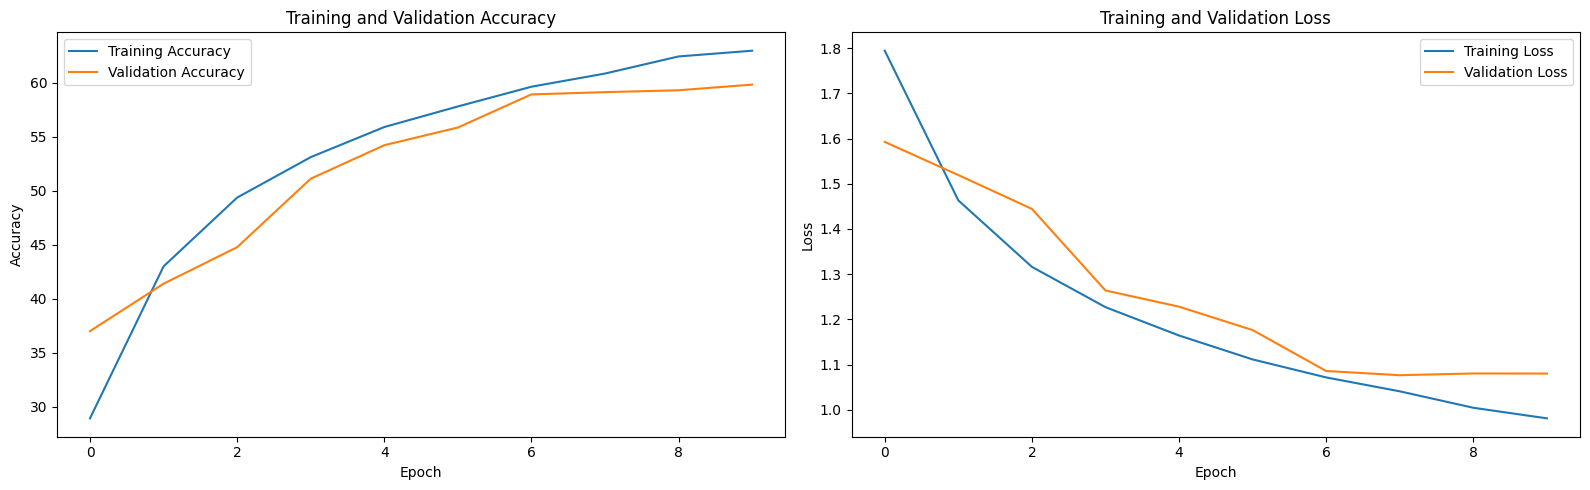

tensor([[14119,   173,  2874,  4698,  5828,  6596,  1330,     1,     1,     0],
        [ 1265,   363,   571,   504,   329,   715,   183,     0,     0,     0],
        [ 4603,    69,  9083,  4523,  5578,  8116,  4723,     1,     3,     1],
        [ 1885,    19,  1455, 53043,  4099,  3361,  1481,     1,     6,     0],
        [ 3122,    15,  2222,  6609, 23432,  8081,  1141,     2,     5,     1],
        [ 4500,    71,  3778,  5535,  9232, 19407,  1022,     1,     4,     0],
        [ 1015,     9,  2901,  3165,  1940,  1092, 18476,     0,     2,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')


In [24]:
# plot final metrics
plot_metrics(metrics_res)
confmat = confmat.compute()
print(confmat)

In [25]:
metrics_res["train_acc"]

[28.918646954098616,
 42.98320303429058,
 49.34979487576438,
 53.09234460871585,
 55.87893799829708,
 57.78311014784426,
 59.60987692545863,
 60.82901153340042,
 62.41195138942643,
 62.94217818716619]

### Training on the pre-trained ResNet model

In [26]:
# use pre-trained model
import torchvision.models as models
# model_pretrained = models.vgg16(pretrained=True)
# model_pretrained.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
# model_pretrained.classifier[6] = nn.Linear(model_pretrained.classifier[6].in_features, 7)
# Unfreeze the final fully connected layer
# for param in model_pretrained.classifier[6].parameters():
  #  param.requires_grad = True

model_pretrained = models.resnet18(pretrained=True)
model_pretrained.fc = torch.nn.Linear(model_pretrained.fc.in_features, num_classes)

for param in model_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model_pretrained.fc.parameters():
    param.requires_grad = True


# the pre-trained model requires a different kind of transforms: re-load the data
pre_train_loader, pre_val_loader, pre_test_loader = get_data_loaders(full_path, batch_size=32,pre_trained=True)

# Hyperparameters
learning_rate = 0.001
num_epochs = 10

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer (only for the unfrozen layers)
optimizer = torch.optim.Adam(model_pretrained.fc.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

model_pretrained = model_pretrained.to(device)

# Training
metrics_pretrained,confmat = train(pre_train_loader, pre_val_loader, model_pretrained, loss_fn, optimizer, num_epochs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.0MB/s]


Epoch 1/10, Train Loss: 1.6325, Train Acc: 35.87%, Val Loss: 1.5701, Val Acc: 39.39%
Epoch 2/10, Train Loss: 1.5395, Train Acc: 40.73%, Val Loss: 1.5349, Val Acc: 40.54%
Epoch 3/10, Train Loss: 1.5230, Train Acc: 41.32%, Val Loss: 1.5366, Val Acc: 42.18%
Epoch 4/10, Train Loss: 1.5078, Train Acc: 41.88%, Val Loss: 1.4836, Val Acc: 44.62%
Epoch 5/10, Train Loss: 1.5094, Train Acc: 41.81%, Val Loss: 1.5454, Val Acc: 39.50%
Epoch 6/10, Train Loss: 1.5013, Train Acc: 42.12%, Val Loss: 1.5355, Val Acc: 41.17%
Epoch 7/10, Train Loss: 1.4968, Train Acc: 42.22%, Val Loss: 1.4859, Val Acc: 43.82%
Epoch 8/10, Train Loss: 1.4937, Train Acc: 42.68%, Val Loss: 1.5200, Val Acc: 43.92%
Epoch 9/10, Train Loss: 1.4947, Train Acc: 42.69%, Val Loss: 1.4897, Val Acc: 42.98%
Epoch 10/10, Train Loss: 1.4910, Train Acc: 42.57%, Val Loss: 1.4899, Val Acc: 42.95%
Done training!


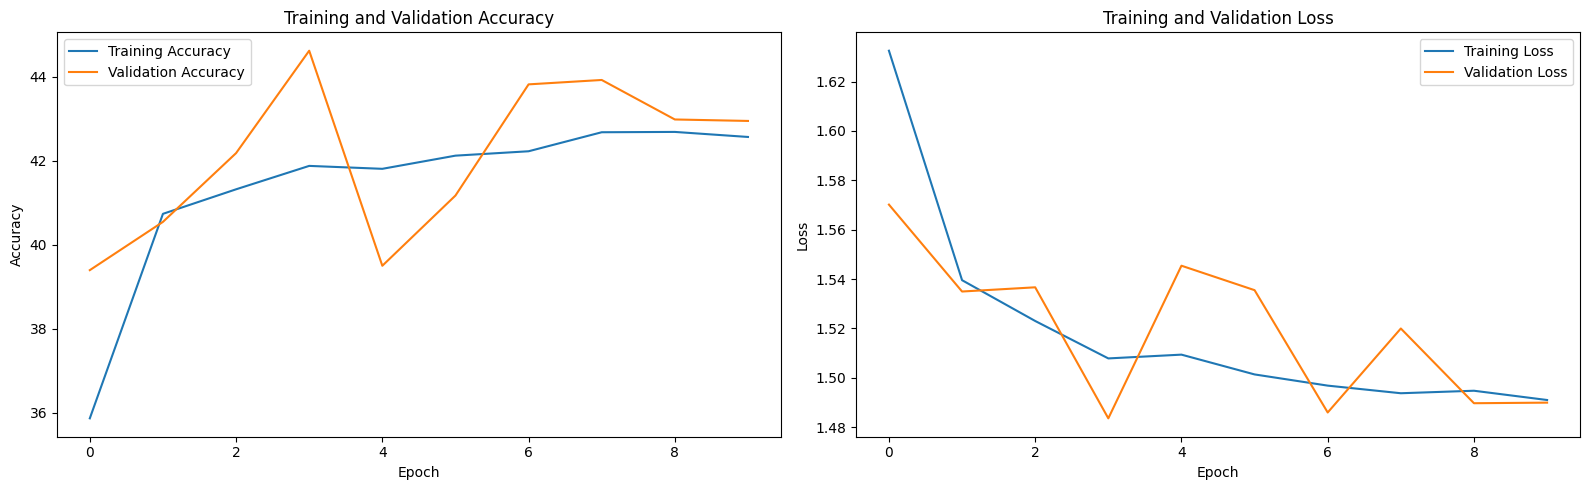

tensor([[ 8509,    41,  3702,  9432,  5243,  6916,  2167,     0,     0,     0],
        [  607,    72,   550,  1313,   361,   822,   175,     0,     0,     0],
        [ 3913,    39,  7458,  8127,  4924,  7367,  5232,     0,     0,     0],
        [ 3905,    38,  3323, 42474,  6134,  6261,  2565,     0,     0,     0],
        [ 3121,    18,  3254, 10674, 17701,  6939,  2523,     0,     0,     0],
        [ 4515,    27,  4475, 10448,  7568, 15318,  1389,     0,     0,     0],
        [ 1531,    15,  3254,  4082,  3110,  1343, 15405,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')


In [27]:
# plot metrics
plot_metrics(metrics_pretrained)
confmat = confmat.compute()
print(confmat)

### Comparing the models

In [28]:
train_acc_simple = max(metrics["train_acc"])
train_acc_res = max(metrics_res["train_acc"])
train_acc_pretrained = max(metrics_pretrained["train_acc"])

val_acc_simple = max(metrics["val_acc"])
val_acc_res = max(metrics_res["val_acc"])
val_acc_pretrained = max(metrics_pretrained["val_acc"])

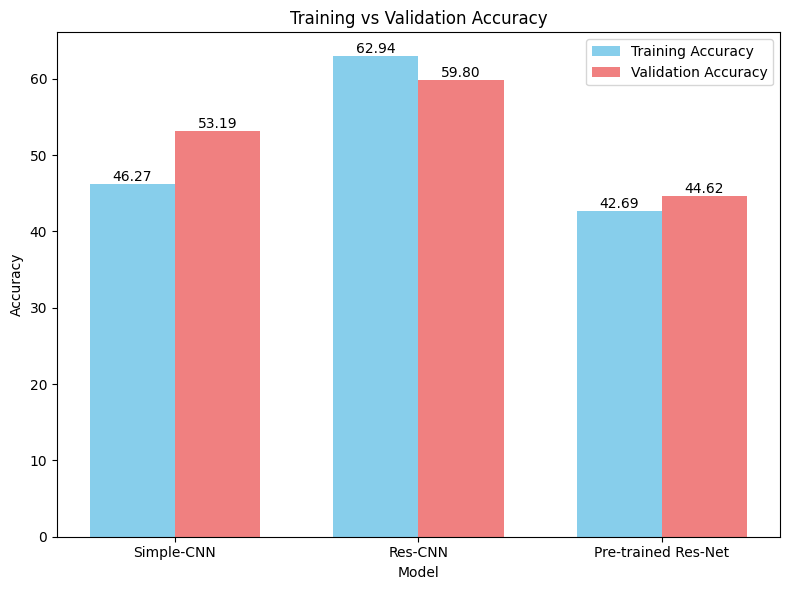

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
models = ["Simple-CNN", "Res-CNN", "Pre-trained Res-Net"]
training_accuracies = [train_acc_simple, train_acc_res, train_acc_pretrained]  # Replace with your values
validation_accuracies = [val_acc_simple, val_acc_res, val_acc_pretrained]      # Replace with your values

x = np.arange(len(models))  # Position of each model
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training and validation accuracies side by side
bars1 = ax.bar(x - width/2, training_accuracies, width, label='Training Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, validation_accuracies, width, label='Validation Accuracy', color='lightcoral')

# Add labels, title, and legend
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_title("Training vs Validation Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




In [36]:
# Save the entire model as a pickle file
PATH = './fer-2013-cnn.pth'
torch.save(model_res, PATH)